# Machine Learning Model Monitoring



# Setup

## Update libraries

In [1]:
%pip install pandas==1.2.4
%pip install --upgrade scikit-learn==0.24.2
%pip install --upgrade scipy==1.6.2
%pip install shap==0.39

Requirement already up-to-date: scikit-learn==0.24.2 in /usr/local/lib/python3.7/dist-packages (0.24.2)
Requirement already up-to-date: scipy==1.6.2 in /usr/local/lib/python3.7/dist-packages (1.6.2)


## Setup Colab

In [2]:
COLAB = True

if COLAB:
    from google.colab import drive
    # Mount Google Drive
    drive.mount('/gdrive')

    # Move to projects folder
    %cd '/gdrive/MyDrive/Projects' 
    %ls

Mounted at /gdrive
/gdrive/MyDrive/Projects
EntrySignals.ipynb  novartis-datathon-2018/
interviews/         novartis-datathon-2020/


In [3]:
GIT_REPOSITORY = "novartis-datathon-2020"

if COLAB:
    # PARENT_DIRECTORY_PATH = "/content"
    # In case you want to clone in your drive:
    PARENT_DIRECTORY_PATH = "/gdrive/MyDrive/Projects"
    PROJECT_PATH = PARENT_DIRECTORY_PATH + "/" + GIT_REPOSITORY
    %cd "{PROJECT_PATH}"

/gdrive/MyDrive/Projects/novartis-datathon-2020


In [4]:
%ls data

gx_num_generics.csv      logs/
gx_package.csv           processed/
gx_panel.csv             rolling_forecasting_image.xlsx
gx_therapeutic_area.csv  submission_instructions.pdf
gx_volume.csv            submission_template.csv


# Load libraries

In [5]:
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style("darkgrid")    # or white
sns.set_context("notebook")  # or paper

from joblib import dump, load
from pathlib import Path
from src.config import *
from src.features.encoders import CyclicalEncoder

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"Python: {sys.version}")

Numpy: 1.19.5
Pandas: 1.2.4
Seaborn: 0.11.1
Python: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [6]:
win_size = "win_len_24"
model_class = "HistGradientBoostingRegressor"

In [7]:
path_figures = Path("figures")
path_features = PATH_DATA_PROCESSED /  win_size
sub_folder = PATH_MODELS / win_size / model_class
print(path_features, sub_folder, sep = "\n")

/gdrive/MyDrive/Projects/novartis-datathon-2020/data/processed/win_len_24
/gdrive/MyDrive/Projects/novartis-datathon-2020/models/win_len_24/HistGradientBoostingRegressor


In [8]:
list(sub_folder.glob("model_y_*.joblib") )

[PosixPath('/gdrive/MyDrive/Projects/novartis-datathon-2020/models/win_len_24/HistGradientBoostingRegressor/model_y_0.joblib'),
 PosixPath('/gdrive/MyDrive/Projects/novartis-datathon-2020/models/win_len_24/HistGradientBoostingRegressor/model_y_1.joblib'),
 PosixPath('/gdrive/MyDrive/Projects/novartis-datathon-2020/models/win_len_24/HistGradientBoostingRegressor/model_y_2.joblib'),
 PosixPath('/gdrive/MyDrive/Projects/novartis-datathon-2020/models/win_len_24/HistGradientBoostingRegressor/model_y_3.joblib'),
 PosixPath('/gdrive/MyDrive/Projects/novartis-datathon-2020/models/win_len_24/HistGradientBoostingRegressor/model_y_4.joblib'),
 PosixPath('/gdrive/MyDrive/Projects/novartis-datathon-2020/models/win_len_24/HistGradientBoostingRegressor/model_y_5.joblib'),
 PosixPath('/gdrive/MyDrive/Projects/novartis-datathon-2020/models/win_len_24/HistGradientBoostingRegressor/model_y_6.joblib'),
 PosixPath('/gdrive/MyDrive/Projects/novartis-datathon-2020/models/win_len_24/HistGradientBoostingRegres

# Load model files

In [9]:
class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [10]:
def clean_key(name):
  return name.replace("model_", "")

In [11]:
def collect_metrics(scores_all: dict):
  # custom_order = {k: i for i, k in enumerate(scores_all.keys())}
  custom_order = {f"y_{i}": i for i, k in enumerate(scores_all.keys())}
  summary_scores = (
      pd.concat(all_scores, keys=custom_order, names=["model"])
      .rename({"level_0": "model"}, axis=1)
      .groupby("model")
      .agg(["mean", "std"])
      .sort_index(key=lambda x: x.map(custom_order))
  )
  summary_scores.columns = ["_".join(col).strip() for col in summary_scores.columns.values]
  return summary_scores

# Model performance

In [12]:
model_files = list(sub_folder.glob("model_y_*.joblib") )
all_scores = {clean_key(f.stem): load(f).get("cv_results") for f in model_files}
all_scores_df = collect_metrics(all_scores)
all_scores_df.head(3)

,fit_time_mean,fit_time_std,score_time_mean,score_time_std,test_MAE_mean,test_MAE_std,train_MAE_mean,train_MAE_std,test_MAPE_mean,test_MAPE_std,train_MAPE_mean,train_MAPE_std,test_COV_mean,test_COV_std,train_COV_mean,train_COV_std
model,,,,,,,,,,,,,,,,
y_0,586.198516,31.800289,0.02244,0.007782,-0.103214,0.005179,-0.077314,0.008049,-0.173527,0.026358,-0.128682,0.011151,0.935844,0.007731,0.940937,0.003061
y_1,630.781660,83.791068,0.02062,0.005000,-0.102555,0.004064,-0.072525,0.012335,-0.251085,0.072188,-0.175549,0.036403,0.940397,0.013361,0.940391,0.002333
y_2,461.082744,30.403739,0.02575,0.010704,-0.075953,0.002106,-0.034486,0.016596,-0.231281,0.101184,-0.104537,0.045869,0.947150,0.008514,0.955959,0.001586


In [13]:
# all_scores = load(sub_folder / "all_scores.joblib")
# all_scores_df = collect_metrics(all_scores)
# all_scores_df.head(4)

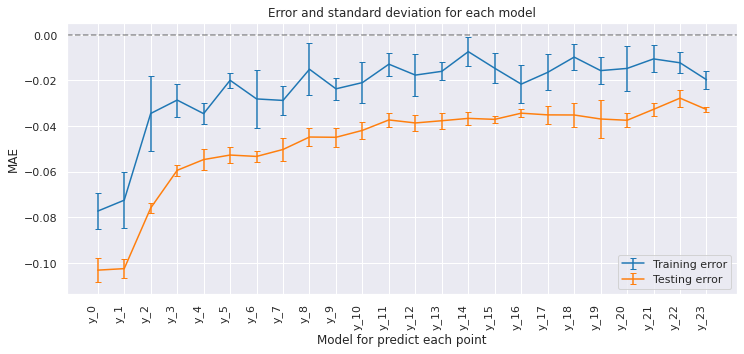

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
_ = ax.axhline(y=0, c="black", alpha=0.4, linestyle="--")
_ = ax.errorbar(all_scores_df.index, all_scores_df.train_MAE_mean,
                 yerr=all_scores_df.train_MAE_std, capsize=3,
                 label='Training error')
             
_ = ax.errorbar(all_scores_df.index, all_scores_df.test_MAE_mean,
                 yerr=all_scores_df.test_MAE_std, capsize=3,
                 label='Testing error')
_ = ax.legend()
_ = ax.set_xlabel("Model for predict each point")
_ = ax.set_ylabel("MAE")
_ = ax.set_title("Error and standard deviation for each model")
_ = plt.xticks(rotation=90, ha='right')
_ = plt.savefig(path_figures / 'mae_train_error.png', bbox_inches='tight')

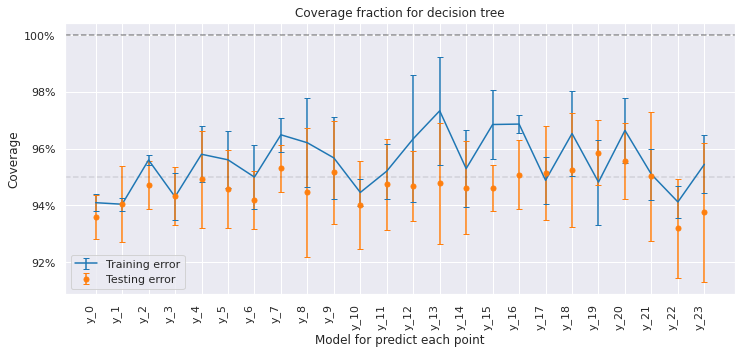

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))
_ = ax.axhline(y=1.0, c="black", alpha=0.4, linestyle="--")
_ = ax.axhline(y=0.95, c="black", alpha=0.1, linestyle="--")
_ = ax.errorbar(all_scores_df.index, all_scores_df.train_COV_mean,
                yerr=all_scores_df.train_COV_std, capsize=3,
                label='Training error')
             
_ = ax.errorbar(all_scores_df.index, all_scores_df.test_COV_mean,
                yerr=all_scores_df.test_COV_std, capsize=3, 
                fmt='o', markersize=5,
                label='Testing error')
_ = ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
_ = ax.legend()
_ = ax.set_xlabel("Model for predict each point")
_ = ax.set_ylabel("Coverage")
_ = ax.set_title("Coverage fraction for decision tree")
_ = plt.xticks(rotation=90, ha='right')
_ = plt.savefig(path_figures / 'coverage_train_error.png', bbox_inches='tight')

# Predictions vs Target

In [16]:
all_preds = {clean_key(f.stem): load(f).get("predictions") for f in model_files}
# custom_order = {f"y_{i}": i for i, k in enumerate(all_preds.keys())}
custom_order = [f"y_{i}" for i, _ in enumerate(all_preds.keys())]
all_preds = {k: all_preds[k] for k in custom_order}
all_preds_df = pd.concat(all_preds, names=["model"])
all_preds_df.reset_index(inplace=True)
all_preds_df.sort_values(by=["country", "brand"], inplace=True)
all_preds_df.head()

,model,country,brand,y_true,y_low,y_pred,y_high
0,y_0,country_1,brand_10,0.866219,0.853408,1.133480,1.413552
982,y_1,country_1,brand_10,0.715418,0.321520,0.593410,0.865301
1955,y_2,country_1,brand_10,0.690338,0.567852,0.776131,0.984409
2920,y_3,country_1,brand_10,0.632416,0.449134,0.614297,0.779459
3872,y_4,country_1,brand_10,0.628897,0.505351,0.662286,0.819222


In [17]:
# # Load all predictions
# all_preds = load(sub_folder / "all_preds.joblib")
# all_preds_df = pd.concat(all_preds)
# all_preds_df.head()

In [18]:
load(sub_folder / "model_y_0.joblib").get("conf_interval_std")

0.2800719226163095

In [19]:
from sklearn.metrics import r2_score

def plot_predicted_vs_target(y_true, y_pred, title=None, ax=None):
  """Scatter plot of the predicted vs true targets."""
  if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    _ = ax.set_xlabel('Measured')
    _ = ax.set_ylabel('Predicted')
  _ = ax.plot([y_true.min(), y_true.max()], 
              [y_true.min(), y_true.max()], 
              "--", color="brown", linewidth=2)
  _ = ax.scatter(y_true, y_pred, alpha=0.1)
  _ = ax.set_xlim([y_true.min(), y_true.max()])
  _ = ax.set_ylim([y_true.min(), y_true.max()])
  _ = ax.set_title(title)

  # R2
  extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                        edgecolor='none', linewidth=0)
  text = r'$R^2={:.2f}$'.format(r2_score(y_true, y_pred))
  _ = ax.legend([extra], [text], loc='upper left', fontsize="small", 
                handletextpad=0)
  return ax

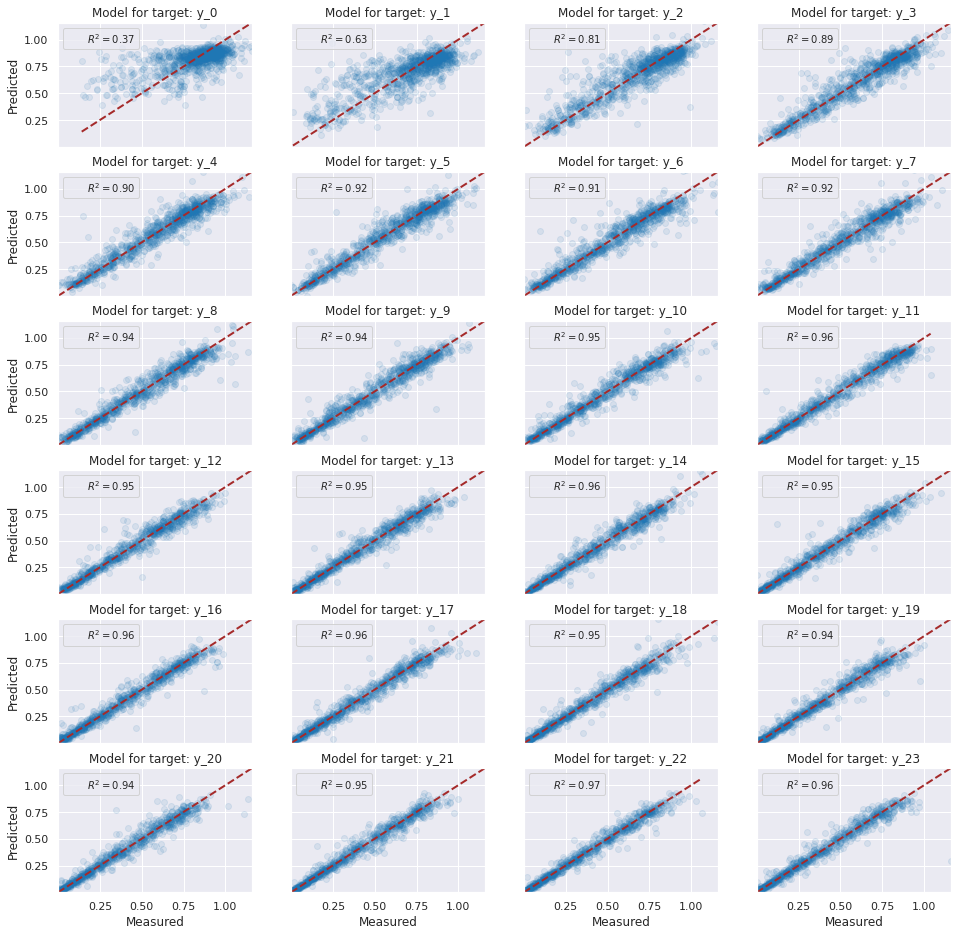

In [20]:
fig, axs = plt.subplots(6, 4, figsize=(16, 16), sharex=True, sharey=True)
for target_col, ax in zip(all_preds.keys(), fig.get_axes()):
  plot_data = all_preds.get(target_col)
  _ = plot_predicted_vs_target(plot_data["y_true"], plot_data["y_pred"], 
                               title=f"Model for target: {target_col}", ax=ax)

# set labels
_ = plt.setp(axs[-1, :], xlabel="Measured")
_ = plt.setp(axs[:, 0], ylabel="Predicted")
_ = plt.savefig(path_figures / 'predicted_vs_target.png', bbox_inches='tight')

# Generics Custom Metric

In [21]:
from src.features.encoders import VolumeNormalizer
from src.metrics.metrics import GenericsCustomMetric

In [22]:
mapping = load(PATH_DATA_PROCESSED / "mapping_volume.joblib")
scaler = VolumeNormalizer(mapping=mapping)

In [23]:
all_preds_df.head()

,model,country,brand,y_true,y_low,y_pred,y_high
0,y_0,country_1,brand_10,0.866219,0.853408,1.133480,1.413552
982,y_1,country_1,brand_10,0.715418,0.321520,0.593410,0.865301
1955,y_2,country_1,brand_10,0.690338,0.567852,0.776131,0.984409
2920,y_3,country_1,brand_10,0.632416,0.449134,0.614297,0.779459
3872,y_4,country_1,brand_10,0.628897,0.505351,0.662286,0.819222


In [24]:
# only keep products with 24 monhts
all_preds_df_ = all_preds_df.groupby(["country", "brand"]).filter(lambda x: len(x) == 24)
print("Number of products with 24 months of forecast: {}".format(
    all_preds_df_[["country", "brand"]].drop_duplicates().shape[0]
))

Number of products with 24 months of forecast: 768


In [25]:
# post-processing
all_preds_df_["actuals"] = scaler.inverse_transform(all_preds_df_, col="y_true")
all_preds_df_["lower_bound"] = scaler.inverse_transform(all_preds_df_, col="y_low")
all_preds_df_["forecast"] = scaler.inverse_transform(all_preds_df_, col="y_pred")
all_preds_df_["upper_bound"] = scaler.inverse_transform(all_preds_df_, col="y_high")

# no negative values allowed
all_preds_df_["lower_bound"] = all_preds_df_["lower_bound"].clip(0, None)
all_preds_df_["forecast"] = all_preds_df_["forecast"].clip(0, None)
all_preds_df_["upper_bound"] = all_preds_df_["upper_bound"].clip(0, None)

all_preds_df_.head()

,model,country,brand,y_true,y_low,y_pred,y_high,actuals,lower_bound,forecast,upper_bound
0,y_0,country_1,brand_10,0.866219,0.853408,1.133480,1.413552,3001009.56,2.956628e+06,3.926935e+06,4.897243e+06
982,y_1,country_1,brand_10,0.715418,0.321520,0.593410,0.865301,2478559.40,1.113902e+06,2.055867e+06,2.997831e+06
1955,y_2,country_1,brand_10,0.690338,0.567852,0.776131,0.984409,2391672.84,1.967319e+06,2.688899e+06,3.410480e+06
2920,y_3,country_1,brand_10,0.632416,0.449134,0.614297,0.779459,2191002.10,1.556023e+06,2.128226e+06,2.700430e+06
3872,y_4,country_1,brand_10,0.628897,0.505351,0.662286,0.819222,2178810.02,1.750784e+06,2.294487e+06,2.838190e+06


In [26]:
evaluator = GenericsCustomMetric()
metrics_df = evaluator.score(all_preds_df_)

In [27]:
np.mean(np.abs(metrics_df))

custom_metric          5.339315
uncertainty_metric    31.254952
dtype: float64

| Model class          	| window size 	| Custom metric 	| Uncertainty metric 	|
|----------------------	|-------------	|---------------	|--------------------	|
| HistGradientBoosting 	| 24          	| 5,34          	| 31,25              	|
| HistGradientBoosting 	| 48          	| 5,35          	| 31,08              	|
| RandomForest         	| 24          	| 5,59          	| 32,48              	|
| RandomForest         	| 48          	| 5,65          	| 32,72              	| 

# Plot predictions

Plot training predictions

In [28]:
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload

In [29]:
from src.visualization.visualize import plot_volume

In [30]:
all_preds_df_2 = all_preds_df_.rename({
    "lower_bound": "pred_95_low", "upper_bound": "pred_95_high"}, axis=1)
all_preds_df_2["month_num"] = all_preds_df_2.groupby(["country", "brand"]).cumcount()
all_preds_df_2.head()

,model,country,brand,y_true,y_low,y_pred,y_high,actuals,pred_95_low,forecast,pred_95_high,month_num
0,y_0,country_1,brand_10,0.866219,0.853408,1.133480,1.413552,3001009.56,2.956628e+06,3.926935e+06,4.897243e+06,0
982,y_1,country_1,brand_10,0.715418,0.321520,0.593410,0.865301,2478559.40,1.113902e+06,2.055867e+06,2.997831e+06,1
1955,y_2,country_1,brand_10,0.690338,0.567852,0.776131,0.984409,2391672.84,1.967319e+06,2.688899e+06,3.410480e+06,2
2920,y_3,country_1,brand_10,0.632416,0.449134,0.614297,0.779459,2191002.10,1.556023e+06,2.128226e+06,2.700430e+06,3
3872,y_4,country_1,brand_10,0.628897,0.505351,0.662286,0.819222,2178810.02,1.750784e+06,2.294487e+06,2.838190e+06,4


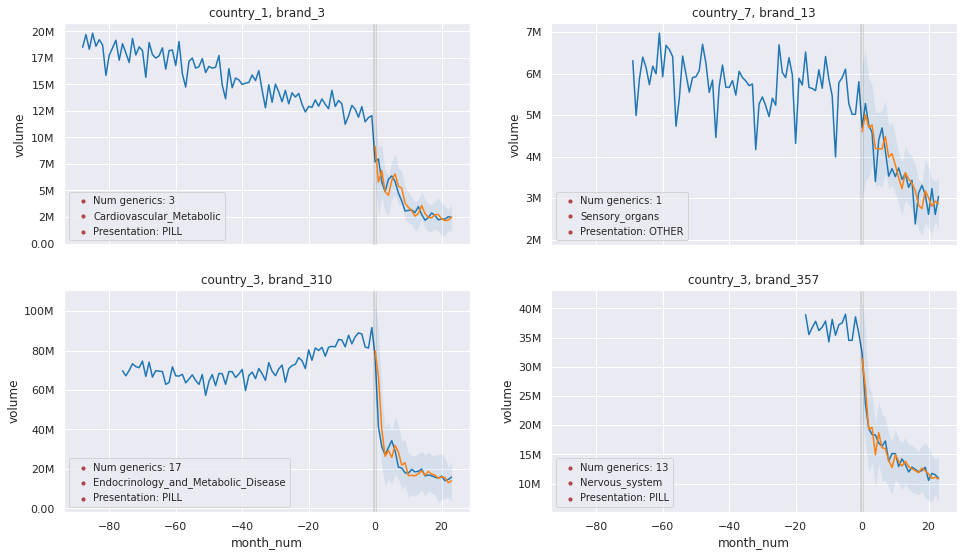

In [31]:
rows = 2
fig, axs = plt.subplots(rows, 2, figsize=(16, 4.5*rows), sharex=True)
products = [
  ("country_1", "brand_3"), ("country_7", "brand_13"), 
  ("country_3", "brand_310"), ("country_3", "brand_357")
]
for p, ax in zip(products, fig.get_axes()):
  _  = plot_volume(cc=p[0], bb=p[1], y_col="volume", predictions=all_preds_df_2, ax=ax)

_ = plt.savefig(path_figures / 'train_forecast.png', bbox_inches='tight')

Show me more

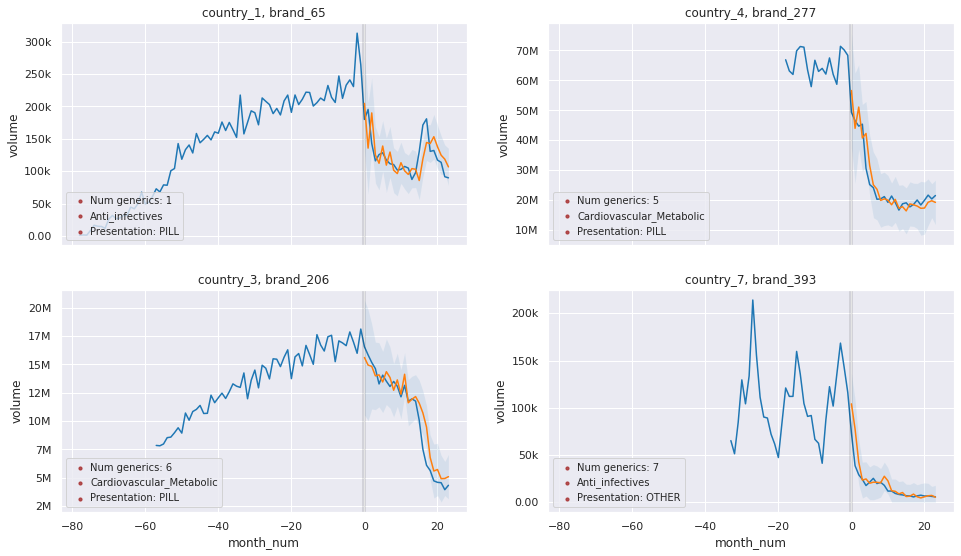

In [32]:
rows = 2
fig, axs = plt.subplots(rows, 2, figsize=(16, 4.5*rows), sharex=True)
products = [
  ("country_1", "brand_65"), ("country_4", "brand_277"), 
  ("country_3", "brand_206"), ("country_7", "brand_393")
]
for p, ax in zip(products, fig.get_axes()):
  _  = plot_volume(cc=p[0], bb=p[1], y_col="volume", predictions=all_preds_df_2, ax=ax)

# Plot forecast

Plot forecast to the future

In [33]:
submission = load(sub_folder / "forecast_predictions.joblib")
submission.head()

,country,brand,month_num,pred_95_low,prediction,pred_95_high,forecast
0,country_1,brand_121,0,2.293773e+07,0.909330,4.360483e+07,33271281.68
1,country_1,brand_121,1,2.769074e+06,0.348956,2.276665e+07,12767862.80
2,country_1,brand_121,2,1.395549e+05,0.215112,1.560184e+07,7870696.96
3,country_1,brand_121,3,9.498128e+05,0.190721,1.300669e+07,6978249.04
4,country_1,brand_121,4,1.565998e+06,0.197424,1.288098e+07,7223488.72


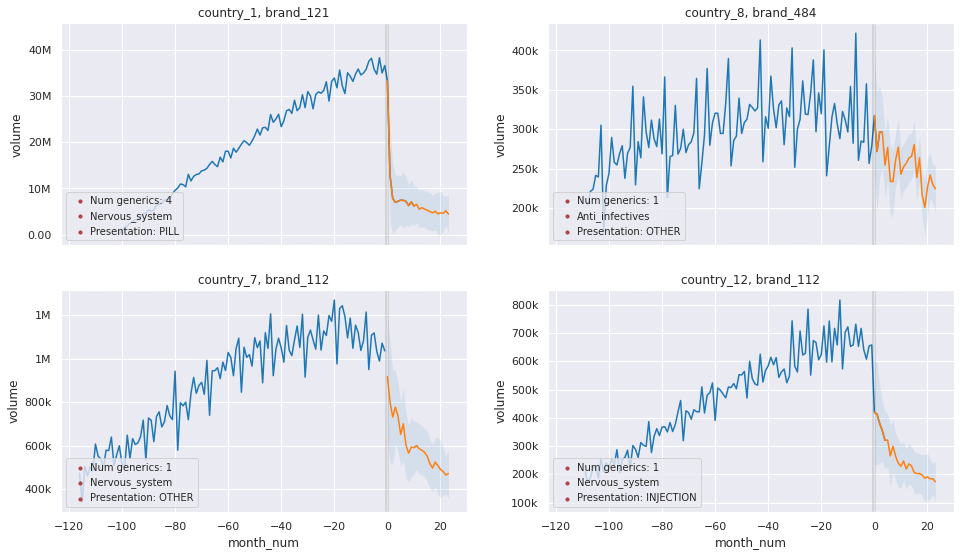

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(16, 4.5*2), sharex=True)
products = [
  # ("country_1", "brand_121"), ("country_1", "brand_128"), 
  # ("country_8", "brand_484"), ("country_8", "brand_51"), 
  ("country_1", "brand_121"), ("country_8", "brand_484"), 
  ("country_7", "brand_112"), ("country_12", "brand_112")
]
for p, ax in zip(products, fig.get_axes()):
  _  = plot_volume(cc=p[0], bb=p[1], y_col="volume", predictions=submission, 
                   ax=ax)
  
_ = plt.savefig(path_figures / 'submission_forecast.png', bbox_inches='tight')

Show me more

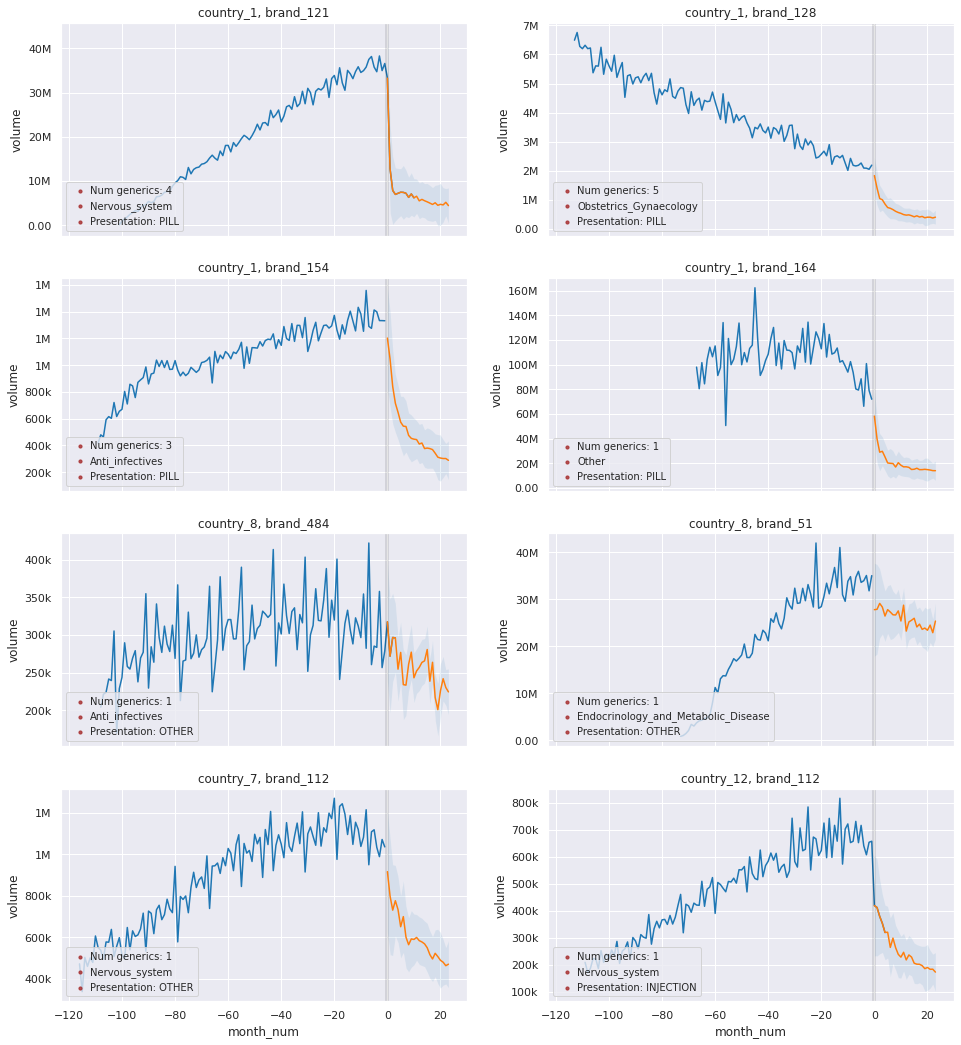

In [35]:
fig, axs = plt.subplots(4, 2, figsize=(16, 4.5*4), sharex=True)
products = [
  ("country_1", "brand_121"), ("country_1", "brand_128"), 
  ("country_1", "brand_154"), ("country_1", "brand_164"),
  ("country_8", "brand_484"), ("country_8", "brand_51"), 
  # ("country_8", "brand_70"), ("country_8", "brand_92"),
  ("country_7", "brand_112"), ("country_12", "brand_112")
]
for p, ax in zip(products, fig.get_axes()):
  _  = plot_volume(cc=p[0], bb=p[1], y_col="volume", predictions=submission, 
                   ax=ax)

# Shap values

In [42]:
import shap
from src.features.encoders import get_feature_names_

import ipywidgets as widgets

In [43]:
# list(path_features.glob("features_for_*.joblib"))

In [45]:
# Create the list of all labels for the drop down list
list_of_labels = [f"y_{i}" for i in range(24)]

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, list_of_labels))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels, value="y_0", 
                                 description='Select Model:')

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

Dropdown(description='Select Model:', options=(('y_0', 'y_0'), ('y_1', 'y_1'), ('y_2', 'y_2'), ('y_3', 'y_3'),…

In [46]:
target_col = current_label.label

# Load data for this model
X = load(path_features / f"features_for_{target_col}.joblib").get("X")

# Create object that can calculate shap values
models = load(sub_folder / f"model_{target_col}.joblib").get("models")
feature_names = load(sub_folder / f"model_{target_col}.joblib").get("features")

# Get pre-processor and model from the pipeline
this_model = models[0].best_estimator_[-1]   # Last element of the pipeline
this_preproc = models[0].best_estimator_[0]  # First element of the pipeline
explainer = shap.TreeExplainer(this_model)

# Get pre-processed feature names
feature_names_preproc = get_feature_names_(
    this_preproc, feature_names)

# Calculate shap_values for all of val_X rather than a single row, 
# to have more data for plot.
Xt = this_preproc.transform(X)
shap_values = explainer.shap_values(Xt)

ordinal-encoder
['country', 'brand', 'therapeutic_area', 'presentation']
cyclical-encoder
['month_name_sin' 'month_name_cos']
knn-imputer
['lag_24', 'lag_23', 'lag_22', 'lag_21', 'lag_20', 'lag_19', 'lag_18', 'lag_17', 'lag_16', 'lag_15', 'lag_14', 'lag_13', 'lag_12', 'lag_11', 'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6', 'lag_5', 'lag_4', 'lag_3', 'lag_2', 'lag_1']
remainder
remainder
['num_generics', 'channel_rate_A', 'channel_rate_B', 'channel_rate_C', 'channel_rate_D', 'month_min', 'growth_before_gx']


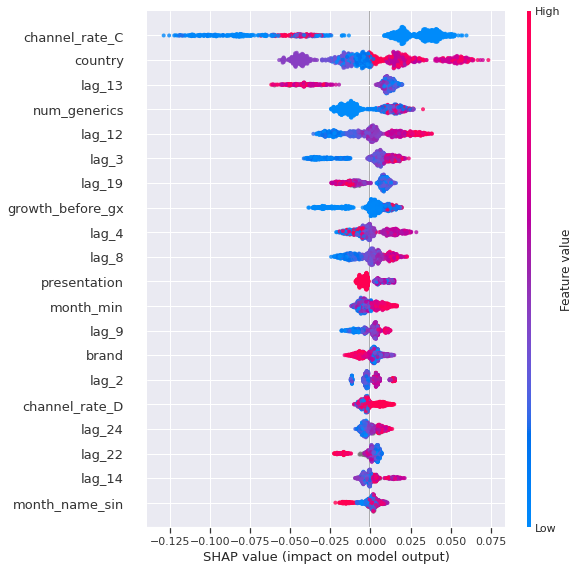

In [74]:
shap.summary_plot(shap_values, Xt, feature_names=feature_names_preproc, 
                  title=target_col, alpha=0.8, show=False)
_ = plt.savefig(path_figures / 'shap_values.png', bbox_inches='tight')

In [ ]:
# Create a widget for the labels and then display the widget
current_feat = widgets.Dropdown(options=feature_names_preproc, 
                                value="num_generics", 
                                description='Select Feature:')

# Display the dropdown list (Note: access index value with 'current_label.value')
current_feat

Dropdown(description='Select Feature:', index=54, options=('country', 'brand', 'therapeutic_area', 'presentati…

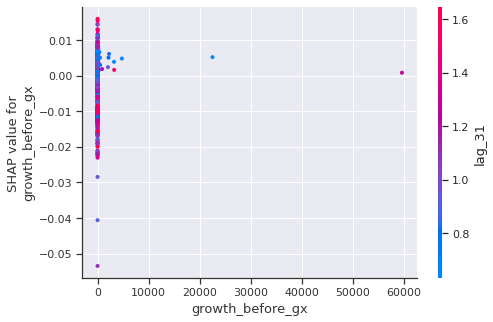

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot(current_feat.label, shap_values, Xt, feature_names=feature_names_preproc)

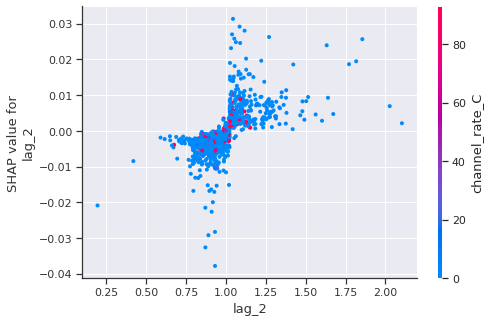

In [ ]:
shap.dependence_plot("lag_2", shap_values, 
                     features=pd.DataFrame(Xt, columns=feature_names_preproc), 
                     interaction_index="channel_rate_C")

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [ ]:
print(f'Current Model Shown: {current_label.label}\n')

# print the JS visualization code to the notebook
shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[1, :],
    features=feature_names_preproc,
    figsize=(12, 3)
)

Current Model Shown: y_0



If we take many explanations such as the one shown above, we can see explanations for an entire dataset:

In [48]:
# print the JS visualization code to the notebook
shap.initjs()

# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[:200], 
                features=feature_names_preproc)